In [40]:
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import os
import glob
import seaborn as sns
import random
import shutil
import re

# Load dataset

In [2]:
def load_image_dataset(directory):
    # Load the face cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')


    # List of image file extensions to read
    image_exts = ['jpg', 'jpeg', 'png', 'bmp']
    i=0
    # Detect faces in all images in the directory
    faces_list = []
    label = []
    for ext in image_exts:
        for filename in glob.glob(os.path.join(directory, f'*.{ext}')):
            temp = os.path.splitext(os.path.basename(filename))[0]
            i = i+1
    #         print(i,'read image :',temp)
            img = cv2.imread(filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
            x, y, w, h = faces[0]
            face = img[y:y+h, x:x+w]
            faces_list.append(face)
            label.append(temp)
            
    return faces_list,label
    
    

In [3]:
directory = './img'

faces_list,label = load_image_dataset(directory)

# Preprocessing

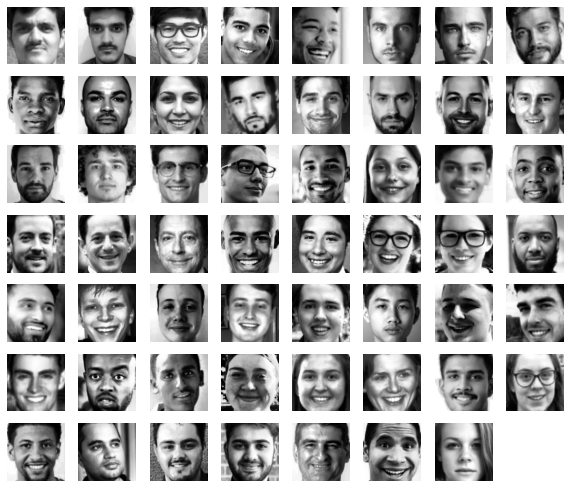

In [4]:

def preprocess(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply histogram equalization
    eq = cv2.equalizeHist(blur)

    return eq

def preprocess_images(images, target_size):
    preprocessed_images = []
    for image in images:
        resized_image = cv2.resize(image, target_size)
        preprocessed_image = preprocess(resized_image)
        preprocessed_images.append(preprocessed_image)
    return preprocessed_images

def display_images(images, preprocessed_images):
    # Display the faces
    if len(preprocessed_images) > 0:
        fig = plt.figure(figsize=(10, 10))
        num_faces = len(preprocessed_images)
        rows = cols = int(num_faces**0.5) + 1 if int(num_faces**0.5)**2 < num_faces else int(num_faces**0.5)
        for i, face in enumerate(preprocessed_images):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
            plt.axis('off')

        plt.show()
    else:
        print('No faces detected in any images.')

# Example usage
target_size = (224, 224) 
preprocessed_face_images = preprocess_images(faces_list,target_size)
display_images(faces_list, preprocessed_face_images)


In [ ]:



# Assuming you have your images in a list of (image, label) tuples
images_and_labels = [...]  # Fill this with your actual data

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=3000)

# Prepare data for model training
data = []
labels = []

for image, label in images_and_labels:
    # Detect and compute the descriptors with ORB
    kp, des = orb.detectAndCompute(image, None)
    
    # You need to convert your descriptors into a format that can be used by KNN. 
    # One simple (but not necessarily optimal) way to do this is to flatten them into a 1D array.
    if des is not None:
        data.append(des.flatten())
        labels.append(label)

# Encode the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# In case any image has fewer descriptors, we need to 'pad' our data so that all images 
# are represented by feature vectors of the same length. We can do this by finding the 
# image with the most descriptors and padding all other images to match this length.

# Pad the data
max_length = max(len(row) for row in data)
data = np.array([np.pad(row, (0, max_length - len(row))) for row in data])

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.1)

# Train a KNN classifier on the data
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainY)

# Test the model
print(model.score(testX, testY))


# Image features extract using orb

In [8]:
def extract_image_features_orb(preprocessed_face_images):
    data = []
    orb = cv2.ORB_create(nfeatures=3000)
    for image in preprocessed_face_images:
        # Detect and compute the descriptors with ORB
        kp, des = orb.detectAndCompute(image, None)

        # convert your descriptors into a format that can be used by KNN. 
        # One simple (but not necessarily optimal) way to do this is to flatten them into a 1D array.
        if des is not None:
            data.append(des.flatten())
        
    print(len(data))
    
    return data


In [10]:
orb_features = extract_image_features_orb(preprocessed_face_images)

55


# Training and Testing Dataset

In [15]:
def padding_dataset(data):
# Pad the data
    max_length = max(len(row) for row in data)
    data_p = np.array([np.pad(row, (0, max_length - len(row))) for row in data])    
    
    return data_p

In [28]:
X_train = orb_features
y_train = label 
# X_train = padding_dataset(X_train)

In [29]:
test_dir = './test_images/'
X_test,y_test = load_image_dataset(test_dir)
X_test = preprocess_images(X_test,target_size)
X_test = extract_image_features_orb(X_test)
# X_test = padding_dataset(X_test)

10


In [30]:
print("Length of Train dataset",len(X_train))
print("Length of Test dataset",len(X_test))

Length of Train dataset 55
Length of Test dataset 10


In [31]:
# Find the maximum length across both the training and testing data
max_length = max(max(len(row) for row in X_train), max(len(row) for row in X_test))

# Pad the training and testing data to the maximum length
X_train = np.array([np.pad(row, (0, max_length - len(row))) for row in X_train])
X_test = np.array([np.pad(row, (0, max_length - len(row))) for row in X_test])

In [32]:
y_test = np.array([re.findall(r'\d+', item)[0] for item in y_test])
y_train = np.array([re.findall(r'\d+', item)[0] for item in y_train])

# Training Model

# KNN Model

In [33]:
# Train a KNN classifier on the data
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=3)

In [36]:
# Predict labels for the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.2


# SVM Model

In [41]:
# Train an SVM classifier on the training data
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict labels for the testing data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0
